<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/ds-project-Stratified-based-Geospatial-Online-Sampling/blob/time-profiling/code/4.S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    TRIPS_PATH = "/content/drive/MyDrive/Project/"
else:
    TRIPS_PATH = "../data/"
TRIPS_PATH += "NYC_Pilot2_PM_Part1.csv"

if IN_COLAB:
    POLYGON_PATH = "/content/drive/MyDrive/Project/"
else:
    POLYGON_PATH = "../data/"
POLYGON_PATH += "nyc_polygon.geojson"

In [3]:
!pip install s2


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv'
POLYGON_PATH='https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson'


In [4]:
import pandas as pd
import folium
import geopandas as gpd
from shapely.geometry import Polygon
import plotly.express as px
from datetime import datetime
from s2 import s2

# Data Analysis on Trips pickup

In [6]:
sampling_fraction = 0.6
s2_resolution = 14

In [7]:
trips = pd.read_csv(TRIPS_PATH)

In [8]:
trips = \
trips[(trips['latitude'] != 0 ) & \
(trips['longitude']!=0 )]

In [9]:
trips['s2'] = trips.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis=1)

In [10]:
trips['s2'].nunique()

163

In [11]:
# %%time
# convert to Geopandas Geodataframe
gdf_trips = gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude))

In [12]:
# The CRS for trips should remain geographic 4326
gdf_trips.set_crs('epsg:4326', inplace=True)

SensorID        time   latitude  longitude  bin0  bin1  bin2  bin3  \
0       NYCP2_CS01A  1631277304  40.847672 -73.869316    11     1     1     0   
1       NYCP2_CS01A  1631277308  40.847668 -73.869316    22     4     1     0   
2       NYCP2_CS01A  1631277313  40.847649 -73.869362    40     1     1     0   
3       NYCP2_CS01A  1631277318  40.847649 -73.869362    26     1     0     0   
4       NYCP2_CS01A  1631277323  40.847649 -73.869362    44     4     0     1   
...             ...         ...        ...        ...   ...   ...   ...   ...   
169994  NYCP2_CS03A  1631457109  40.823353 -73.890488   115    11     2     0   
169995  NYCP2_CS03A  1631457114  40.823349 -73.890480   132     8     2     0   
169996  NYCP2_CS03A  1631457119  40.823349 -73.890480   147    14     0     0   
169997  NYCP2_CS03A  1631457124  40.823345 -73.890488   121     8     2     0   
169998  NYCP2_CS03A  1631457129  40.823338 -73.890488   135     8     1     0   

        bin4  bin5  ...  bin19  bin20  bin21  bin22  bin23  temperature  \
0          0     0  ...      0      0      0      0      0         23.7   
1          0     2  ...      0      0      0      0      0         23.7   
2          0     1  ...      0      0      0      0      0         23.7   
3          0     0  ...      0      0      0      0      0         23.6   
4          0     0  ...      0      0      0      0      0         23.6   
...      ...   ...  ...    ...    ...    ...    ...    ...          ...   
169994     1     0  ...      0      0      0      0      0         24.6   
169995     0     0  ...      0      0      0      0      0         24.6   
169996     0     0  ...      0      0      0      0      0         24.6   
169997     1     1  ...      0      0      0      0      0         24.6   
169998     1     1  ...      0      0      0      0      0         24.6   

        humidity      pm25        s2                    geometry  
0           57.3  4.508813  89c2f499  POINT (-73.86932 40.84767)  
1           57.8  5.462420  89c2f499  POINT (-73.86932 40.84767)  
2           57.8  5.154881  89c2f499  POINT (-73.86936 40.84765)  
3           57.6  4.508813  89c2f499  POINT (-73.86936 40.84765)  
4           57.5  5.539503  89c2f499  POINT (-73.86936 40.84765)  
...          ...       ...       ...                         ...  
169994      54.8  5.460360  89c2f455  POINT (-73.89049 40.82335)  
169995      54.8  5.298209  89c2f455  POINT (-73.89048 40.82335)  
169996      54.8  6.470661  89c2f455  POINT (-73.89048 40.82335)  
169997      54.6  6.424142  89c2f455  POINT (-73.89049 40.82335)  
169998      54.6  6.526187  89c2f455  POINT (-73.89049 40.82334)  

[169999 rows x 33 columns]

In [13]:
# BASELINE: original Neighbourhoods
geojson_file = POLYGON_PATH
neighborhoods_original = gpd.read_file(geojson_file)

In [14]:
# %%time

sjoined_trips_original = gpd.sjoin(gdf_trips, neighborhoods_original, predicate="within")
sjoined_trips_original.head(2)

SensorID        time   latitude  longitude  bin0  bin1  bin2  bin3  \
0  NYCP2_CS01A  1631277304  40.847672 -73.869316    11     1     1     0   
1  NYCP2_CS01A  1631277308  40.847668 -73.869316    22     4     1     0   

   bin4  bin5  ...  temperature  humidity      pm25        s2  \
0     0     0  ...         23.7      57.3  4.508813  89c2f499   
1     0     2  ...         23.7      57.8  5.462420  89c2f499   

                     geometry  index_right  neighborhood  boroughCode  \
0  POINT (-73.86932 40.84767)           38    Bronx Park            2   
1  POINT (-73.86932 40.84767)           38    Bronx Park            2   

   borough                                                @id  
0    Bronx  http://nyc.pediacities.com/Resource/Neighborho...  
1    Bronx  http://nyc.pediacities.com/Resource/Neighborho...  

[2 rows x 38 columns]

In [15]:
# %%time
# sampling by s2
sampled_s2_data = sjoined_trips_original.groupby('s2').apply(lambda x: x.sample(frac=sampling_fraction))

In [16]:
# sampled data scenario
NYC_pickup= sampled_s2_data['neighborhood'].value_counts()
NYC_pickup = NYC_pickup.reset_index()
NYC_pickup.columns = ['neighborhood','count']
NYC_pickup['neighborhood'] = NYC_pickup['neighborhood'].astype(str)

In [17]:
#reference geo-map
# NYC_pickup["neighborhood"].astype(str)
geo_path = POLYGON_PATH
# heatmap_scale = list()
# threshold = [10,20,50,70,85,100]
# for i in threshold :
#     heatmap_scale.append(int(NYC_pickup['count'].max() * (i/100.0)))

map_NYC_pickup = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
folium.Choropleth(geo_data=geo_path, data=NYC_pickup, \
                data_out = 'nyc_zip_test.json',
             columns=['neighborhood', 'count'],
             #threshold_scale= heatmap_scale,
             key_on='feature.properties.neighborhood',
             fill_color='YlOrRd', fill_opacity=0.9, line_opacity=0.9,nan_fill_color='white',
             legend_name='Number of Pickups').add_to(map_NYC_pickup)

In [18]:
map_NYC_pickup

In [19]:
def generateBaseMap(default_location=[40.7306, -73.935], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [20]:
sampled_s2_data_copy = sampled_s2_data.sample(frac=1)
sampled_s2_data_copy['count'] = 1

In [21]:
base_map = generateBaseMap()

In [22]:
from folium.plugins import HeatMap
HeatMap(data=sampled_s2_data_copy[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [23]:
base_map

# Data Analysis on pm25

In [5]:
sampling_fraction = 0.6
s2_resolution = 14

In [10]:
trips = pd.read_csv(TRIPS_PATH)

In [11]:
trips['s2'] = trips.apply(lambda x: s2.geo_to_s2(x.latitude, x.longitude, s2_resolution), axis=1)
trips_cut = trips[['pm25', 's2', 'latitude', 'longitude']]
sampled_trips = trips_cut.groupby('s2').apply(lambda x: x.sample(frac = sampling_fraction))
sampled_trips.drop('s2', axis=1, inplace=True)
sampled_trips.head()

C:\Users\MMadi\AppData\Local\Temp\ipykernel_33752\4231907630.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = trips_cut.groupby('s2').apply(lambda x: x.sample(frac = sampling_fraction))


pm25   latitude  longitude
s2                                              
89c25eab 161393   3.187280  40.711689 -73.934052
89c25efd 161392   3.084182  40.740944 -73.898811
89c25f55 978     11.503020  40.785488 -73.930382
         37798    4.457077  40.786270 -73.930107
89c25f57 980     12.318045  40.784996 -73.929497

In [12]:
df_pm25 = (sampled_trips
                          .groupby('s2')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())# Let's count each points inside the hexagon

df_pm25['average_pm25_value'] =(df_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)))

In [13]:
df_pm25.sort_values('average_pm25_value',ascending=False)

s2                                          pm25_list  \
162  89c2f5fb                                      [11.85305332]   
4    89c25fd9  [12.50628639, 11.53301632, 8.078673324, 12.729...   
159  89c2f5ef  [11.63097866, 4.457077097, 11.98490562, 11.984...   
160  89c2f5f1  [11.50302009, 11.98490562, 11.50302009, 11.853...   
3    89c25f57  [12.31804457, 9.899690654, 11.50302009, 3.0841...   
..        ...                                                ...   
40   89c2f379                         [2.383764287, 2.383764287]   
48   89c2f411                                      [2.367734371]   
124  89c2f5a3  [2.24837233, 2.24837233, 2.812337479, 2.248372...   
47   89c2f40f                                      [2.292275858]   
150  89c2f5d7  [2.200473882, 2.200473882, 2.200473882, 2.2004...   

     average_pm25_value  
162           11.853053  
4             10.810646  
159            9.974667  
160            9.820010  
3              9.231155  
..                  ...  
40             2.383764  
48             2.367734  
124            2.361165  
47             2.292276  
150            2.243465  

[163 rows x 3 columns]

In [14]:
from shapely.geometry import Polygon
def add_geometry(row):
  points = s2.s2_to_geo_boundary(row['s2'], True)
  return Polygon(points)
  #Apply function into our dataframe
df_pm25['geometry'] = (df_pm25.apply(add_geometry,axis=1))

In [32]:
%pip install geojson

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from geojson import Feature, FeatureCollection

def s2_dataframe_to_geojson(df_s2, hex_id_field,geometry_field, value_field):
    return FeatureCollection([
        Feature(
            geometry = row[geometry_field],
            id = row[hex_id_field],
            properties = {"value": row[value_field]}
        ) for _, row in df_s2.iterrows()
    ])

In [16]:
geojson_obj = (s2_dataframe_to_geojson
                (df_pm25,
                 hex_id_field='s2',
                 value_field='average_pm25_value',
                 geometry_field='geometry'))

In [17]:
fig = (px.choropleth_mapbox(
                    df_pm25,
                    geojson=geojson_obj,
                    locations='s2',
                    color='average_pm25_value',
                    color_continuous_scale="Viridis",
                    range_color=(min(df_pm25['average_pm25_value']),max(df_pm25['average_pm25_value'])),
                    mapbox_style='carto-positron',
                    zoom=10,
                    center = {"lat": 40.8, "lon": -73.83},
                    opacity=0.7,
                    labels={'average_pm25_value':'pm25 level'}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [36]:
gdf_trips = gpd.GeoDataFrame(df_pm25, geometry = df_pm25.geometry)

In [37]:
print(gdf_trips.crs)

None


In [38]:
gdf_trips.set_crs('epsg:4326', inplace = True)

s2  average_pm25_value  \
0    89c25eab            3.187280   
1    89c25efd            3.084182   
2    89c25f55            7.980049   
3    89c25f57           10.433847   
4    89c25fd9           10.730193   
..        ...                 ...   
158  89c2f5ed            4.457077   
159  89c2f5ef            9.494754   
160  89c2f5f1           10.482156   
161  89c2f5f9            7.851531   
162  89c2f5fb           11.503020   

                                              geometry  
0    POLYGON ((-73.93598 40.71382, -73.93598 40.708...  
1    POLYGON ((-73.90071 40.74338, -73.90071 40.738...  
2    POLYGON ((-73.93598 40.78792, -73.93598 40.782...  
3    POLYGON ((-73.93010 40.78708, -73.93010 40.782...  
4    POLYGON ((-73.84779 40.75063, -73.84779 40.745...  
..                                                 ...  
158  POLYGON ((-73.91835 40.80021, -73.91835 40.795...  
159  POLYGON ((-73.92423 40.80105, -73.92423 40.796...  
160  POLYGON ((-73.92423 40.79611, -73.92423 40.791...  
161  POLYGON ((-73.93010 40.79202, -73.93010 40.787...  
162  POLYGON ((-73.93010 40.79695, -73.93010 40.792...  

[163 rows x 3 columns]

In [39]:
geojson_file = POLYGON_PATH
neighborhoods_original = gpd.read_file(geojson_file)
neighborhoods_original.head()

neighborhood boroughCode        borough  \
0         Allerton           2          Bronx   
1  Alley Pond Park           4         Queens   
2    Arden Heights           5  Staten Island   
3        Arlington           5  Staten Island   
4         Arrochar           5  Staten Island   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry  
0  POLYGON ((-73.84860 40.87167, -73.84582 40.870...  
1  POLYGON ((-73.74333 40.73888, -73.74371 40.739...  
2  POLYGON ((-74.16983 40.56108, -74.16982 40.561...  
3  POLYGON ((-74.15975 40.64142, -74.15998 40.641...  
4  POLYGON ((-74.06078 40.59319, -74.06079 40.593...

In [40]:
neighborhoods_original['neighborhood'].nunique()

266

In [41]:
print(neighborhoods_original.crs)

EPSG:4326


In [42]:
start_time = datetime.now()
sjoined_trips_original = gpd.sjoin(neighborhoods_original, gdf_trips).reset_index(drop = True)
time_elapsed = datetime.now() - start_time
print('time elapsed (hh:mm:ss.ms): {}'.format(time_elapsed))
sjoined_trips_original.head()

time elapsed (hh:mm:ss.ms): 0:00:00.017571


neighborhood boroughCode borough  \
0     Allerton           2   Bronx   
1   Bronx Park           2   Bronx   
2    Bronxdale           2   Bronx   
3     Allerton           2   Bronx   
4   Bronx Park           2   Bronx   

                                                 @id  \
0  http://nyc.pediacities.com/Resource/Neighborho...   
1  http://nyc.pediacities.com/Resource/Neighborho...   
2  http://nyc.pediacities.com/Resource/Neighborho...   
3  http://nyc.pediacities.com/Resource/Neighborho...   
4  http://nyc.pediacities.com/Resource/Neighborho...   

                                            geometry  index_right        s2  \
0  POLYGON ((-73.84860 40.87167, -73.84582 40.870...           77  89c2f49f   
1  POLYGON ((-73.86995 40.85589, -73.86861 40.852...           77  89c2f49f   
2  POLYGON ((-73.86888 40.85722, -73.85639 40.857...           77  89c2f49f   
3  POLYGON ((-73.84860 40.87167, -73.84582 40.870...           32  89c2f361   
4  POLYGON ((-73.86995 40.85589, -73.86861 40.852...           32  89c2f361   

   average_pm25_value  
0            3.979211  
1            3.979211  
2            3.979211  
3            3.163180  
4            3.163180

In [43]:
len(sjoined_trips_original.index)

357

In [44]:
n = len(pd.unique(sjoined_trips_original['neighborhood']))

print("No.of.unique name values :", n)

No.of.unique name values : 55


## QUERY: What is the average pm25 value in each neighborhood in NYC?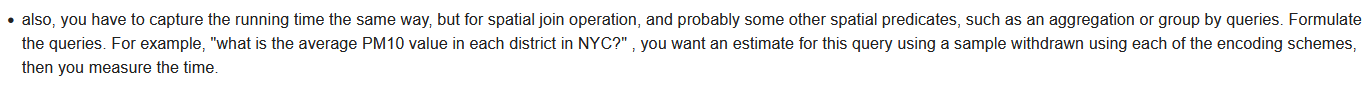


In [45]:
import numpy as np
from timeit import repeat as timeit_repeat
def group_neighborhood(sjoin):
    grouped_neighborhoods = sjoin.groupby('neighborhood', group_keys = False)['average_pm25_value'].mean() #should this be sum or mean? I'm not sure
    df_pm25_neighborhood = pd.DataFrame()
    df_pm25_neighborhood['average_pm25'] = grouped_neighborhoods
    df_pm25_neighborhood = df_pm25_neighborhood.reset_index()
    df_pm25_neighborhood["neighborhood"].astype(str)
    return df_pm25_neighborhood

In [46]:
print("Average of 5 runs for groupby query", np.mean(timeit_repeat(
        "group_neighborhood(sjoined_trips_original)",
        setup="from __main__ import group_neighborhood, sjoined_trips_original",
        repeat=5, number=1)), "seconds")

Average of 5 runs for groupby query 0.0028011600021272897 seconds


In [47]:
grouped_neighborhoods = sjoined_trips_original.groupby('neighborhood', group_keys = False)['average_pm25_value'].mean() #should this be sum or mean? I'm not sure
grouped_neighborhoods

neighborhood
Allerton                         3.359904
Baychester                       3.772947
Belmont                          3.811145
Bronx Park                       3.656866
Bronxdale                        3.700115
Castle Hill                      5.108666
Claremont Village                4.139625
Clason Point                     4.755206
Co-op City                       3.711373
Concourse                        2.980631
Concourse Village                3.731747
Country Club                     4.793140
Crotona Park                     4.972192
East Harlem                      4.867735
East Morrisania                  4.626405
Eastchester                      3.712358
Fieldston                        3.682130
Flushing Meadows Corona Park    10.730193
Fordham                          3.083904
Harlem                           2.783025
Highbridge                       2.906227
Hunts Point                      4.435850
Inwood                           2.884101
Kingsbridge          

In [48]:
df_pm25_neighborhood = pd.DataFrame()
df_pm25_neighborhood['average_pm25'] = grouped_neighborhoods
df_pm25_neighborhood = df_pm25_neighborhood.reset_index()

In [49]:
df_pm25_neighborhood.head()

neighborhood  average_pm25
0     Allerton      3.359904
1   Baychester      3.772947
2      Belmont      3.811145
3   Bronx Park      3.656866
4    Bronxdale      3.700115

In [50]:
max(df_pm25_neighborhood['average_pm25'])

10.73019254635503

In [51]:
df_pm25_neighborhood["neighborhood"].astype(str)
geo_path = POLYGON_PATH
heatmap_scale = list()
threshold = [10,20,50,70,85,100]
for i in threshold :
    heatmap_scale.append(int(df_pm25_neighborhood['average_pm25'].max() * (i/100.0)))

df_pm25_neighborhoodx = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
folium.Choropleth(geo_data=geo_path, data=df_pm25_neighborhood, \
                data_out = 'nyc_zip_test.json',
             columns=['neighborhood', 'average_pm25'],
             #threshold_scale= heatmap_scale,
             key_on='feature.properties.neighborhood',
             fill_color='YlOrRd', fill_opacity=0.9, line_opacity=0.9,nan_fill_color='white',
             legend_name='Average PM25').add_to(df_pm25_neighborhoodx)

In [52]:
df_pm25_neighborhoodx

In [53]:
# %%time
sampled_s2_data = sampled_trips

In [54]:
def generateBaseMap(default_location=[40.7306, -73.935], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [55]:
sampled_s2_data_copy = sampled_s2_data.sample(frac=1)
sampled_s2_data_copy['count'] = 1

In [56]:
base_map = generateBaseMap()

In [57]:
from folium.plugins import HeatMap
HeatMap(data=sampled_s2_data_copy[['latitude', 'longitude', 'pm25']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [58]:
base_map